### Customer Service Agent for Fashion Retailer

## Fashion Finder Agent

The goal of this project is to create an ai agent for a fashion retailer. The agent will suggest items that match the style of the user's past purchases. Given a request to find an item the agent will search through the product database to find an apprpriate item. It wil prioritize items that are similar to those previously purchased by the user, and cross reference these to make sure the purchased items were not returned.

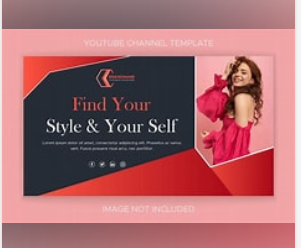

Authenticate API key:

import os

from dotenv import load_dotenv

load_dotenv()

try:
    GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
    if not GOOGLE_API_KEY:
        raise ValueError("GOOGLE_API_KEY not found in .env file")


    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(f"🔑 Authentication Error: Please check your .env file. Details: {e}")


### Import ADK components

In [3]:
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search, AgentTool, ToolContext
from google.adk.code_executors import BuiltInCodeExecutor

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


Define Retry Configurations for LLM calls

In [ ]:
retry_config = types.HttpRetryOptions(
    attempts=5,  
    exp_base=7,  
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  
)

### Custom Tools

We will define custom tools to be used by our customer service agent.

In [ ]:

# Find Customer's purchase history using customer id as input

def get_purchase_history(method: str) -> list:
    """Looks up the customers purchase history

    Args:
        method: The customer's userid  {"userid"}

         Returns:
        dict:
            Success -> {"status": "success", "purchase_history": "<id_string>"}
            Error   -> {"status": "error", "error_message": "Customer history not found"}
    """
    # This simulates looking up a customer's id
    purchase_history_database = {
        #"path to customer_purchase_history database"
    }

    purchase_history = customer_database.get()
    if user_id is not None:
        return {"status": "success", "user_id": id}
    else:
        return {
            "status": "error",
            "error_message": f"No such customer found",
        }


print("✅ Customer purchase history tool created")
print(f"💳 Test: {get_customer_id('abigail454')}")





In [ ]:
# Find  items returned by the customer

def get_customer_returns(method: str) -> dict:
    """Looks up the customer's returns

    Args:
        method: The customer's userid  {"userid"}

         Returns: 
        dict:
            Success -> {"status": "success", "customer_returns": "<list>"}
            Error   -> {"status": "error", "error_message": "Customer not found"}
    """
    # This simulates looking up a customer's id
    cutomer_database = {
        "path to customer_returns database"
    }

    user_id = customer_returns_database.get()
    if user_id is not None:
        return {"status": "success", "": id}
    else:
        return {
            "status": "error",
            "error_message": f"No such customer found",
        }


print("✅ Customer returns lookup tool created")
print(f"💳 Test: {get_customer_returns('abigail454')}")



In [ ]:
# Find similar items to suggest that would match what the customer is looking for


def get_similar_item(method: str) -> dict:
    """Looks up items that would match what the customer is looking for and suit their taste. 
    You will need to compare the items to their past purchases and returns.

    Args:
        method: The customer's userid  {"userid"}
        parameter: The customer's returns {get_purchase_history("userid")}


         Returns:
        dict:
            Success -> {"status": "success", "item_suggestions": "<list>"}
            Error   -> {"status": "error", "error_message": "No item suggestions found"}
    """
    # This simulates looking up available products
    product_database = {
        "path to product database"
    }

    product_id = customer_returns_database.get()
    if product_id is not None:
        return {"status": "success", "": product_id}
    else:
        return {
            "status": "error",
            "error_message": f"No such product found",
        }


print("✅ Customer returns lookup tool created")
print(f"💳 Test: {get_customer_returns('abigail454')}")



In [ ]:
# Customer Service agent for fashion retailer with custom function tools
customer_service_agent = LlmAgent(
    name="customer_agent",
    model=Gemini(model="gemini-2.5-flash-lite", 
                 retry_options=retry_config),
    instruction="""You are a smart customer service assistant for a fashion retailer. You respond in a fun and enthusiastic manner.

    If a customer asks for item recommendations use:
    2. get_purchase_history() to see what they have purchased in the past
    3. get_returns() to check that the items you find have not been returned by the customer 
    3. find_similar_item() to find items simlar to what they have liked in the past
    4. most_popular() to add additional item options to suggest to the shopper

    If any tool returns status "error", explain the issue to the user clearly.
    """,
    tools=[get_customer_id, find_simolar_item, get_purchase_history, get_returns, most_popular],
)

print("✅ Currency agent created with custom function tools")
print("🔧 Available tools:")
print("  • get_suggestion - Looks up items the custome might be interested in")
print("  • get_similar - Look up items that are similar to what the customer is asking for")

In [ ]:
from google.adk.plugins.logging_plugin import (
    LoggingPlugin,
)  
from google.genai import types
import asyncio

Create Customer Service Agent Runner with Logging Plugin

In [ ]:
runner = InMemoryRunner(
    agent=customer_service_agent,
    plugins=[
        LoggingPlugin()
    ],  #  Plugin that Handles standard Observability logging across ALL agents
)

print("✅ Runner configured")